In [27]:
from osgeo import gdal

def check_dim_image_info(tif_path):
    ds = gdal.Open(tif_path)
    if ds is None:
        print("❌ 文件打不开")
        return

    print(f"✅ 成功加载：{tif_path}")
    print(f"📐 尺寸：{ds.RasterXSize} x {ds.RasterYSize}")
    print(f"🧭 仿射矩阵：{ds.GetGeoTransform()}")
    print(f"🌍 投影信息：{ds.GetProjectionRef()}")
    
    band = ds.GetRasterBand(1)
    print(f"📊 数据类型：{gdal.GetDataTypeName(band.DataType)}")
    print(f"📈 像素值范围：{band.GetMinimum()} ~ {band.GetMaximum()}")
    
    stats = band.GetStatistics(True, True)
    print(f"📊 灰度统计：min={stats[0]:.2f}, max={stats[1]:.2f}, mean={stats[2]:.2f}, std={stats[3]:.2f}")

check_dim_image_info(r"E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A.tif")


✅ 成功加载：E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A.tif
📐 尺寸：28583 x 42869
🧭 仿射矩阵：(8845.853800002486, 0.7, 0.0, 1481934.7143000048, 0.0, -0.7000000000000011)
🌍 投影信息：PROJCS["SimpleCylindrical_Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",110],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
📊 数据类型：Byte
📈 像素值范围：0.0 ~ 221.0
📊 灰度统计：min=0.00, max=221.00, mean=118.24, std=8.96


In [63]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt


In [64]:
# 替换为你的 .tif 文件路径（建议使用原始 DIM 图）
tif_path = r"E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A\HX1_GRAS_HIRIC_DIM_0.7_0008_244453N1101905E_A.tif"

with rasterio.open(tif_path) as src:
    data = src.read(1).astype(np.float32)
    nodata = src.nodata
    if nodata is not None:
        data[data == nodata] = np.nan

    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    score_map = (data - min_val) / (max_val - min_val)
    score_map = np.clip(score_map, 0, 1)


In [65]:
# 小于 0.35 的像素认为是阴影
threshold = 0.5
shadow_mask = (score_map < threshold).astype(np.uint8)



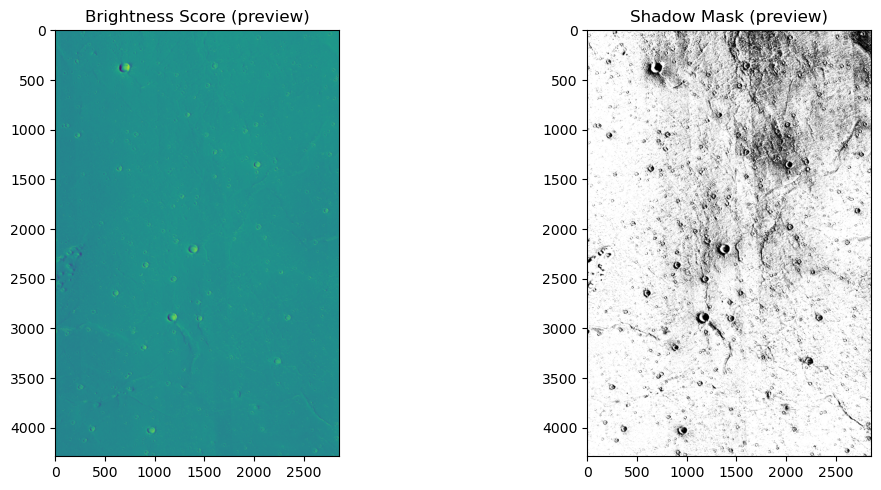

In [66]:
import cv2

# 缩放到原图的 1/10 大小进行可视化
preview_score = cv2.resize(score_map, (0, 0), fx=0.1, fy=0.1)
preview_shadow = cv2.resize(shadow_mask, (0, 0), fx=0.1, fy=0.1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(preview_score, cmap='viridis')
plt.title("Brightness Score (preview)")

plt.subplot(1, 2, 2)
plt.imshow(preview_shadow, cmap='gray')
plt.title("Shadow Mask (preview)")
plt.tight_layout()
plt.show()


In [67]:
import cv2  # 如果没导入过的话加上

# 从全图 score_map 和 shadow_mask 缩放到 preview 版
score_preview = cv2.resize(score_map, (0, 0), fx=0.1, fy=0.1)
shadow_preview = cv2.resize(shadow_mask, (0, 0), fx=0.1, fy=0.1)

print("✅ 预览图已生成：score_preview 和 shadow_preview")

def region_scorer(score_map, shadow_mask, window_size=50, shadow_weight=0.5):
    h, w = score_map.shape
    h_blocks = h // window_size
    w_blocks = w // window_size

    region_scores = np.zeros((h_blocks, w_blocks))

    for i in range(h_blocks):
        for j in range(w_blocks):
            y1, y2 = i * window_size, (i + 1) * window_size
            x1, x2 = j * window_size, (j + 1) * window_size

            brightness_block = score_map[y1:y2, x1:x2]
            shadow_block = shadow_mask[y1:y2, x1:x2]

            brightness_mean = np.nanmean(brightness_block)
            shadow_ratio = np.mean(shadow_block)

            score = brightness_mean - shadow_weight * shadow_ratio
            region_scores[i, j] = score

    return region_scores


✅ 预览图已生成：score_preview 和 shadow_preview


In [33]:
# 你前面缩小后的图变量：
# score_preview, shadow_preview

window_size = 50  # 缩略图建议窗口50×50，对应原图500×500
region_scores = region_scorer(score_preview, shadow_preview, window_size=window_size)


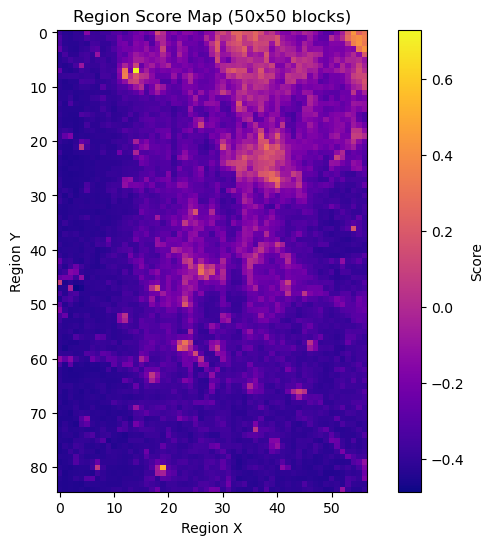

In [68]:
plt.figure(figsize=(8, 6))
plt.imshow(region_scores, cmap='plasma')
plt.title(f"Region Score Map ({window_size}x{window_size} blocks)")
plt.colorbar(label="Score")
plt.xlabel("Region X")
plt.ylabel("Region Y")
plt.show()


In [69]:
N = 5  # top-N 你可以改成10等
top_indices = np.dstack(np.unravel_index(np.argsort(-region_scores.ravel()), region_scores.shape))[0][:N]

print("📍 Top-N 高分区域索引 (block_y, block_x):")
for i, (y, x) in enumerate(top_indices):
    print(f"{i+1}. Block ({y}, {x}) - Score: {region_scores[y, x]:.4f}")


📍 Top-N 高分区域索引 (block_y, block_x):
1. Block (7, 14) - Score: 0.7296
2. Block (80, 19) - Score: 0.5169
3. Block (0, 54) - Score: 0.4286
4. Block (2, 55) - Score: 0.4243
5. Block (3, 56) - Score: 0.4181


In [70]:
def modified_region_scorer(score_map, shadow_mask, window_size=50, lambda_weight=0.5):
    h, w = score_map.shape
    h_blocks = h // window_size
    w_blocks = w // window_size

    region_scores = np.zeros((h_blocks, w_blocks))

    for i in range(h_blocks):
        for j in range(w_blocks):
            y1, y2 = i * window_size, (i + 1) * window_size
            x1, x2 = j * window_size, (j + 1) * window_size

            brightness_block = score_map[y1:y2, x1:x2]
            shadow_block = shadow_mask[y1:y2, x1:x2]

            brightness_mean = np.nanmean(brightness_block)
            shadow_ratio = np.mean(shadow_block)

            score = brightness_mean - lambda_weight * shadow_ratio
            region_scores[i, j] = score

    return region_scores


C:\Users\wyb04\AppData\Local\Temp\ipykernel_23108\1559805065.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


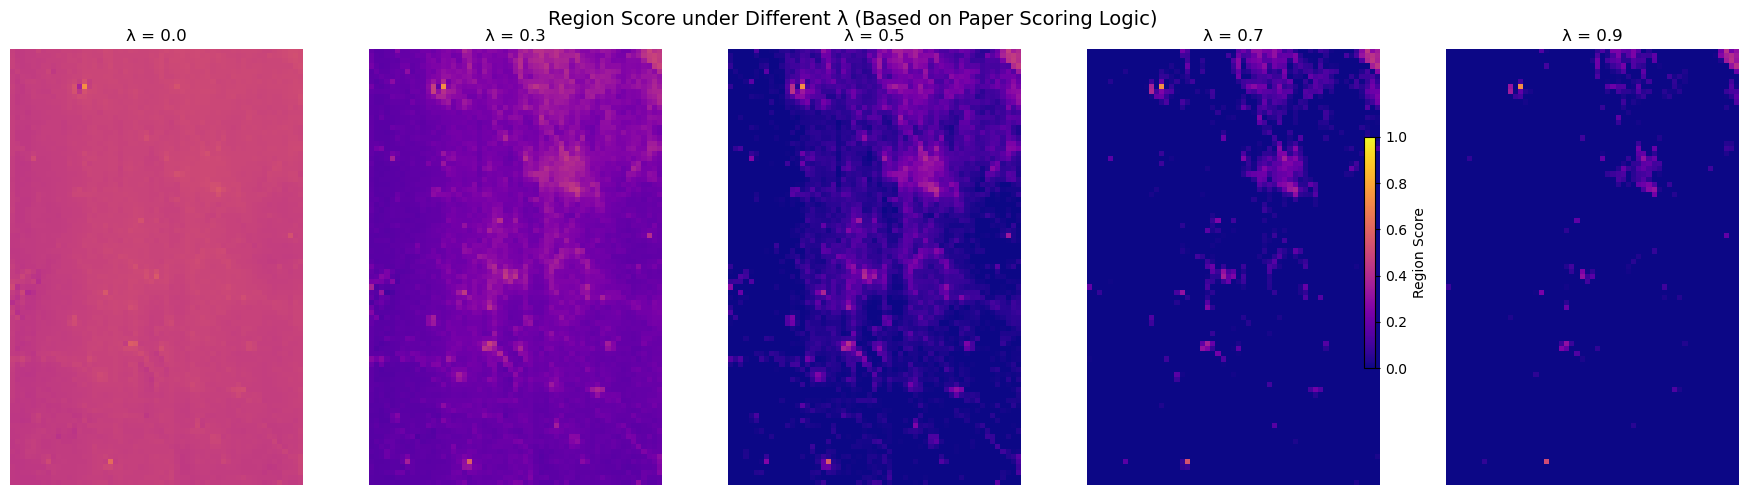

In [71]:
lambda_list = [0.0, 0.3, 0.5, 0.7,0.9]
window_size = 50

fig, axes = plt.subplots(1, len(lambda_list), figsize=(18, 5))

for idx, lam in enumerate(lambda_list):
    region_scores = modified_region_scorer(score_preview, shadow_preview, window_size=window_size, lambda_weight=lam)
    
    im = axes[idx].imshow(region_scores, cmap='plasma', vmin=0, vmax=1)
    axes[idx].set_title(f"λ = {lam}")
    axes[idx].axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='Region Score')
plt.suptitle("Region Score under Different λ (Based on Paper Scoring Logic)", fontsize=14)
plt.tight_layout()
plt.show()


In [38]:
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI

import numpy as np
import rasterio


In [79]:
import pandas as pd

def save_top_regions_to_csv(results: list, output_path: str = "illumination_top_results.csv"):
    df = pd.DataFrame(results)
    df.to_csv(output_path, index=False)
    print(f"✅ 已保存 Top 区域结果至：{output_path}")
# 核心评分函数
def get_top_illumination_regions(tif_path, window_size=500, shadow_threshold=0.35, lambda_weight=0.5, top_k=5):
    with rasterio.open(tif_path) as src:
        data = src.read(1).astype(np.float32)
        transform = src.transform
        nodata = src.nodata
        if nodata is not None:
            data[data == nodata] = np.nan

        brightness = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
        brightness = np.clip(brightness, 0, 1)
        shadow_mask = (brightness < shadow_threshold).astype(np.uint8)

        h, w = brightness.shape
        h_blocks, w_blocks = h // window_size, w // window_size
        region_scores = np.zeros((h_blocks, w_blocks))

        for i in range(h_blocks):
            for j in range(w_blocks):
                y1, y2 = i * window_size, (i + 1) * window_size
                x1, x2 = j * window_size, (j + 1) * window_size
                block = brightness[y1:y2, x1:x2]
                shadow = shadow_mask[y1:y2, x1:x2]
                score = np.nanmean(block) - lambda_weight * np.mean(shadow)
                region_scores[i, j] = score

        top_idx = np.dstack(np.unravel_index(np.argsort(-region_scores.ravel()), region_scores.shape))[0][:top_k]
        results = []
        for rank, (i, j) in enumerate(top_idx, 1):
            y_center = int((i + 0.5) * window_size)
            x_center = int((j + 0.5) * window_size)
            lon, lat = transform * (x_center, y_center)
            results.append({
                "rank": rank,
                "score": round(float(region_scores[i, j]), 4),
                "block": (i, j),
                "pixel_center": (x_center, y_center),
                "map_coord": (round(lon, 2), round(lat, 2))
            })
        save_top_regions_to_csv(results, "illumination_top5.csv")

        return results
#精细化处理函数
def refine_illumination_blocks(
    dim_path: str,
    top_blocks_preview: list,
    preview_window_size: int = 400,
    scale: int = 10,
    lambda_weight: float = 0.5,
    shadow_threshold: float = 0.35,
    top_k: int = 5
):
    with rasterio.open(dim_path) as src:
        full = src.read(1).astype(np.float32)
        transform = src.transform
        nodata = src.nodata
        if nodata is not None:
            full[full == nodata] = np.nan

        # 灰度归一化
        norm = (full - np.nanmin(full)) / (np.nanmax(full) - np.nanmin(full))
        norm = np.clip(norm, 0, 1)
        shadow_mask = (norm < shadow_threshold).astype(np.uint8)

        refined = []
        full_window_size = preview_window_size * scale  # 缩放后对应原图窗口大小

        for idx, (i, j) in enumerate(top_blocks_preview):
            y1 = i * full_window_size
            x1 = j * full_window_size
            y2 = min(y1 + full_window_size, norm.shape[0])
            x2 = min(x1 + full_window_size, norm.shape[1])

            sub = norm[y1:y2, x1:x2]
            shadow = shadow_mask[y1:y2, x1:x2]

            if sub.size == 0:
                continue

            score = np.nanmean(sub) - lambda_weight * np.mean(shadow)
            if np.isnan(score):
                continue

            cx, cy = x1 + (x2 - x1) // 2, y1 + (y2 - y1) // 2
            lon, lat = transform * (cx, cy)

            refined.append({
                "rank": idx + 1,
                "score": round(score, 4),
                "pixel": (cx, cy),
                "map_coord": (round(lon, 2), round(lat, 2)),
                "block": (i, j)
            })


        # 排序并返回前 top_k
        refined_sorted = sorted(refined, key=lambda x: -x["score"])[:top_k]
        return refined_sorted
    


In [80]:
import pandas as pd
import ast
# ✅ 注册 Refine_Light_Zones_csv Tool
def refine_light_tool_entry_csv(input_str: str):
    import pandas as pd
    import ast

    parts = input_str.split(",")
    dim_path = parts[0].strip()
    csv_path = parts[1].strip()
    window = int(parts[2].strip()) if len(parts) > 2 else 400
    lam = float(parts[3].strip()) if len(parts) > 3 else 0.5
    top_k = int(parts[4].strip()) if len(parts) > 4 else 5

    # ✅ 读取 block 信息
    df = pd.read_csv(csv_path)
    block_list = []
    for b in df["block"]:
        b = b.replace("np.int64", "") if "np.int64" in b else b
        block_list.append(ast.literal_eval(b))

    # ✅ 调用精细化函数
    results = refine_illumination_blocks(
        dim_path,
        top_blocks_preview=block_list,
        preview_window_size=window,
        lambda_weight=lam,
        top_k=top_k
    )

    # ✅ 保存结果为 CSV
    refined_df = pd.DataFrame(results)
    save_path = "illumination_refined_top.csv"
    refined_df.to_csv(save_path, index=False)
    print(f"✅ 已保存精细化评分结果至：{save_path}")

    return "\n".join([
        f"{r['rank']}. Block: {r['block']} | 坐标: {r['map_coord']} | 评分: {r['score']}"
        for r in results
    ])




# 用于 Tool 的函数封装（支持字符串参数）
def extract_top_light_zones(input_str):
    parts = input_str.split(",")
    tif_path = parts[0].strip()
    window_size = int(parts[1].strip()) if len(parts) > 1 else 500
    lambda_weight = float(parts[2].strip()) if len(parts) > 2 else 0.5
    top_k = int(parts[3].strip()) if len(parts) > 3 else 5

    results = get_top_illumination_regions(
        tif_path=tif_path,
        window_size=window_size,
        lambda_weight=lambda_weight,
        top_k=top_k
    )

    return "\n".join([f"{r['rank']}. 坐标：{r['map_coord']}, 得分：{r['score']}" for r in results])




In [82]:


# ✅ 注册为 Tool
illumination_tool = Tool(
    name="Select_Light_Zones",
    func=extract_top_light_zones,
    description="根据灰度图评分选出最佳着陆区，输入格式：<路径>, <窗口大小（默认500）>, <λ权重（默认0.5）>, <TopK数量（默认5）>"
)
#精细化处理Tool
refine_light_csv_tool = Tool(
    name="Refine_Light_Zones_From_CSV",
    func=refine_light_tool_entry_csv,
    description=(
        "对 illumination_top5.csv 文件中初筛出的 block 区域进行精细化光照评分，"
        "输入格式为：<DIM路径>, <CSV路径>, <窗口大小（默认400）>, <λ值（默认0.5）>, <TopK数量（默认5）>"
    )
)


In [84]:

# ✅ 初始化通义千问 Agent
llm = ChatOpenAI(
    openai_api_key="sk-45f1d096fb524f1ca2918bd99141b7d3",
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    temperature=0,
    max_tokens=512,
    streaming=False
)

agent = initialize_agent(
    tools=[illumination_tool, refine_light_csv_tool],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)



In [85]:
import matplotlib.pyplot as plt

def plot_refined_results(csv_path):
    df = pd.read_csv(csv_path)
    x = [pt[0] for pt in df["map_coord"].apply(eval)]
    y = [pt[1] for pt in df["map_coord"].apply(eval)]
    scores = df["score"]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=scores, cmap="YlOrBr", s=120, edgecolors='k')
    for i, s in enumerate(scores):
        plt.text(x[i], y[i], f"{i+1}: {s}", fontsize=9, ha='center', va='bottom')
    plt.title("Refined Illumination Top Zones")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


In [86]:
# 替换为你的 DIM 文件路径
tiff_path = "E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A.tif"
prompt1 = f"请用 {tiff_path}找出光照最好的区域，窗口用400，λ用0.6，返回前5个"
response1 = agent.run(prompt1)
print(response1)
csv_path = "E:\Mars\core\illumination_top5.csv"
prompt2 = f"{tiff_path}, {csv_path}, 400, 0.6, 3"
response2 = agent.run(f"请对光照区域做精细评分：{prompt2}")
print(response2)
plot_refined_results("illumination_refined_top.csv")




> Entering new AgentExecutor chain...
我需要使用`Select_Light_Zones`函数来根据给定的参数找出光照最好的区域。
Action: Select_Light_Zones
Action Input: E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A.tif, 400, 0.6, 5✅ 已保存 Top 区域结果至：illumination_top5.csv

Observation: 1. 坐标：(7185.85, 1521354.71), 得分：0.8306
2. 坐标：(-94.15, 1532274.71), 得分：0.8225
3. 坐标：(-374.15, 1532274.71), 得分：0.8192
4. 坐标：(-94.15, 1531994.71), 得分：0.8176
5. 坐标：(-374.15, 1531994.71), 得分：0.8139
Thought:我现在知道了根据给定参数选出的光照最好的前5个区域。
Final Answer: 根据给定条件（窗口大小400，λ值0.6），从文件`E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N1095850E_A.tif`中选出光照最佳的前5个区域如下：

1. 坐标：(7185.85, 1521354.71)，得分：0.8306
2. 坐标：(-94.15, 1532274.71)，得分：0.8225
3. 坐标：(-374.15, 1532274.71)，得分：0.8192
4. 坐标：(-94.15, 1531994.71)，得分：0.8176
5. 坐标：(-374.15, 1531994.71)，得分：0.8139

这些是依据提供的参数筛选出的最佳着陆区。

> Finished chain.
根据给定条件（窗口大小400，λ值0.6），从文件`E:\Mars\data\HX1_GRAS_HIRIC_DIM_0.7_0001_254537N10

EmptyDataError: No columns to parse from file